In [19]:
#%pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0 matplotlib numpy 

In [20]:


import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import tensorflow as tf
import tensorflow_hub as hub
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

In [23]:
classifier_model = inception_v3

In [24]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape = IMAGE_SHAPE+(3,))
])

In [25]:
_URL = "###ENTER URL HERE###"


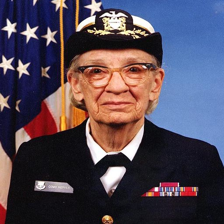

In [26]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [27]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [28]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 358ms/step


(1, 1001)

In [29]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=458>

In [30]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

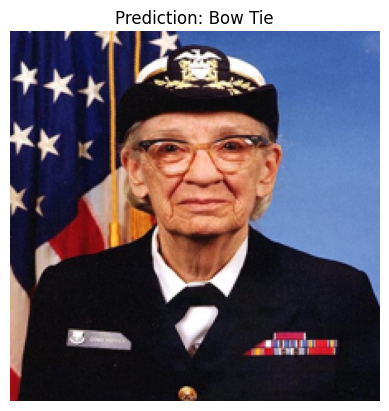

In [31]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [32]:
import pathlib
dataset_url = "https://salford.figshare.com/ndownloader/files/36524085"
data_dir = tf.keras.utils.get_file('dataset', origin=dataset_url, untar=True, cache_dir = '/content')
data_dir = pathlib.Path(data_dir)

In [33]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [34]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 751 files belonging to 10 classes.
Using 676 files for training.


In [35]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 751 files belonging to 10 classes.
Using 150 files for validation.


In [36]:
train_ds = train_dataset
val_ds = validation_dataset

In [37]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Chapman' 'Cockcroft' 'Library' 'Maxwell' 'Media City Campus'
 'New Adelphi' 'New Science' 'Newton' 'Sports Center' 'University House']


In [38]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [39]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2024-11-25 19:25:16.173067: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [41]:
result_batch = classifier.predict(train_ds)

22/22 [==============================] - 17s 550ms/step


In [42]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['scoreboard', 'ashcan', 'flagpole', 'pier', 'freight car', 'barn',
       'tobacco shop', 'prison', 'greenhouse', 'restaurant', 'cinema',
       'greenhouse', 'barn', 'garbage truck', 'pier', 'prison',
       'freight car', 'pier', 'beacon', 'palace', 'library', 'prison',
       'prison', 'pier', 'bookshop', 'tobacco shop', 'container ship',
       'prison', 'flagpole', 'scoreboard', 'freight car', 'cab',
       'mobile home', 'palace', 'barn', 'prison', 'crate', 'lumbermill',
       'lumbermill', 'cinema', 'gondola', 'birdhouse', 'street sign',
       'monastery', 'paddlewheel', 'lakeside', 'prison', 'bell cote',
       'fountain', 'freight car', 'traffic light', 'monastery',
       'greenhouse', 'mobile home', 'lumbermill', 'greenhouse',
       'streetcar', 'library', 'library', 'traffic light', 'boathouse',
       'barn', 'thatch', 'tile roof', 'mailbox', 'lakeside', 'streetcar',
       'suspension bridge', 'liner', 'dam', 'steam locomotive', 'library',
       'prison', 'dam'

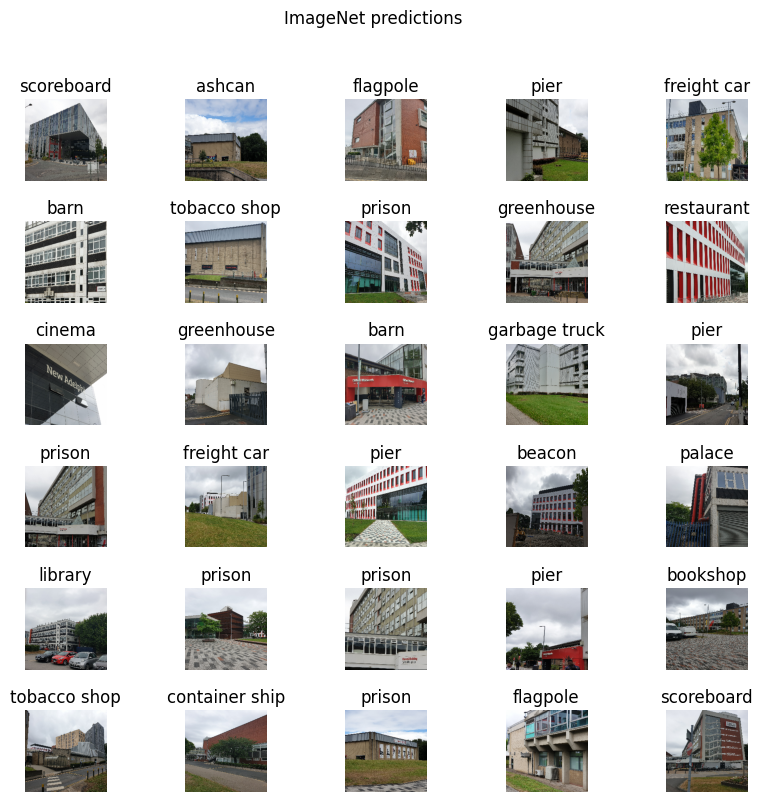

In [43]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [44]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = inception_v3

In [45]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [46]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [47]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21823274 (83.25 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [48]:
predictions = model(image_batch)

In [49]:
predictions.shape

TensorShape([32, 10])

In [50]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [51]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
22/22 [==============================] - 17s 694ms/step - loss: 2.1844 - acc: 0.2663 - val_loss: 1.4908 - val_acc: 0.5267
Epoch 2/10
22/22 [==============================] - 12s 534ms/step - loss: 1.2171 - acc: 0.6317 - val_loss: 1.0253 - val_acc: 0.6933
Epoch 3/10
22/22 [==============================] - 13s 587ms/step - loss: 0.8801 - acc: 0.7604 - val_loss: 0.8079 - val_acc: 0.7600
Epoch 4/10
22/22 [==============================] - 12s 534ms/step - loss: 0.6823 - acc: 0.8299 - val_loss: 0.6973 - val_acc: 0.8000
Epoch 5/10
22/22 [==============================] - 11s 527ms/step - loss: 0.5617 - acc: 0.8713 - val_loss: 0.6317 - val_acc: 0.8133
Epoch 6/10
22/22 [==============================] - 12s 538ms/step - loss: 0.4829 - acc: 0.8920 - val_loss: 0.5818 - val_acc: 0.8333
Epoch 7/10
22/22 [==============================] - 12s 544ms/step - loss: 0.4185 - acc: 0.9201 - val_loss: 0.5316 - val_acc: 0.8333
Epoch 8/10
22/22 [==============================] - 12s 556ms/step - 

In [52]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 14816), started 2 days, 22:29:32 ago. (Use '!kill 14816' to kill it.)

In [53]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 1s 713ms/step
['New Adelphi' 'Sports Center' 'Maxwell' 'Library' 'Newton' 'Cockcroft'
 'Sports Center' 'New Science' 'Maxwell' 'New Science' 'New Adelphi'
 'Chapman' 'Library' 'Library' 'Chapman' 'Maxwell' 'Chapman' 'New Science'
 'New Science' 'Cockcroft' 'Cockcroft' 'Chapman' 'Maxwell' 'Library'
 'Newton' 'Sports Center' 'Maxwell' 'Sports Center' 'University House'
 'Maxwell' 'Chapman' 'Maxwell']


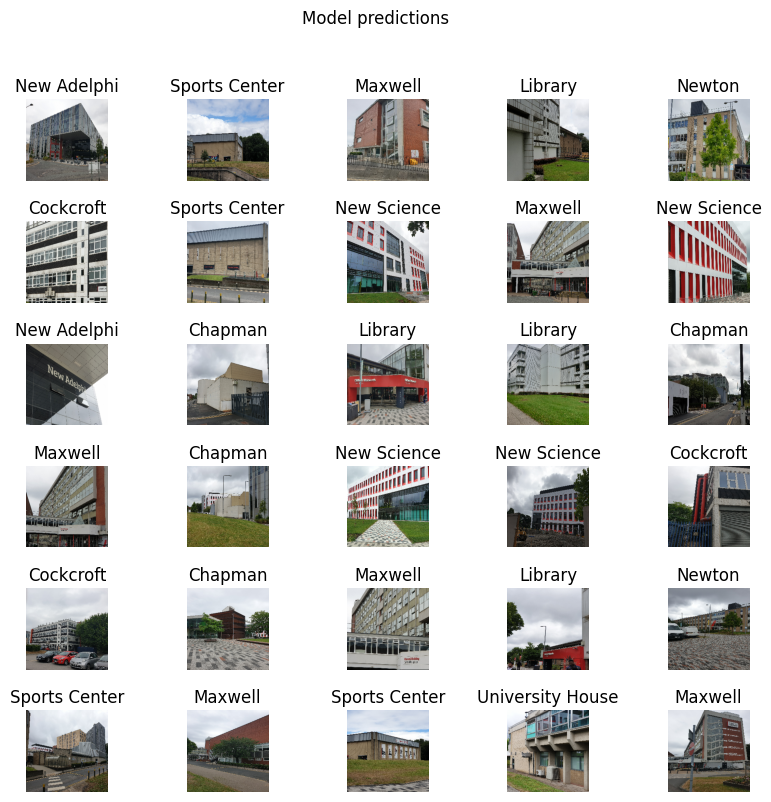

In [54]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [55]:
# import numpy as np
# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming 'test_data' is your test dataset (ImageDataGenerator or TF Dataset)

# # Evaluate the model on the test dataset
# y_true = test_data.classes  # True labels
# y_pred_probs = classifier_model.predict(test_data)  # Predicted probabilities
# y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels

# # Metrics
# print("Accuracy:", accuracy_score(y_true, y_pred))
# print("\nClassification Report:")
# print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

# # Confusion Matrix
# conf_matrix = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=test_data.class_indices.keys(),
#             yticklabels=test_data.class_indices.keys())
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()
